In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
file_path = "/Users/edoardonicoletti/Desktop/EDHEC M2/Risk_Measurament/842 Risk Measurement Hallerbach - data for group assignment.xlsx"

df = pd.read_excel(file_path, sheet_name=None)

df = df['daily_data']

# Set the date column as the index and convert to datetime
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

## RQ1–volatility: 
### what are the ex-ante volatilities of the augmented & default portfolios on Wednesday 11-Dec-2024 close and how does this compare against the course of these ex-ante volatilities over time ?

In [3]:
returns = np.log(df / df.shift(1)).dropna() #Stable returns

/Users/edoardonicoletti/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [4]:
returns.head(3)

,Mkt,Tsies,CorpIG,CorpHY,AR,Oil
date,,,,,,
1995-01-03,-0.002403,-0.002736,-0.002138,0.000572,0.008771,-0.018172
1995-01-04,0.003494,0.004101,0.003679,0.001625,0.006131,0.006284
1995-01-05,-0.000300,-0.004107,-0.002313,0.002017,-0.000290,0.011325


In [5]:
w_default = np.array([0.50, 0.30, 0.05, 0.00, 0.10, 0.05])
w_augmented = np.array([0.40, 0.40, 0.00, 0.05, 0.15, 0.00])

In [6]:
#Calculating returns on both the default and the augmented 
ret_default = returns @ w_default
ret_augmented = returns @ w_augmented

In [7]:
ret_default.head(3)

date
1995-01-03   -0.002161
1995-01-04    0.004089
1995-01-05   -0.000961
dtype: float64

In [8]:
def ewma_volatility(returns, lambda_=0.94): #Decay factor we can choose
    squared_returns = returns**2 #Need to square to calculate the variance
    ewma_var = [squared_returns.iloc[0]]  # start with first value

    for r2 in squared_returns.iloc[1:]: #we loop through all squared returns strating from the second one
        ewma_prev = ewma_var[-1]
        ewma_new = lambda_ * ewma_prev + (1 - lambda_) * r2
        ewma_var.append(ewma_new)

    ewma_vol = pd.Series(np.sqrt(ewma_var), index=squared_returns.index[0:len(ewma_var)])
    return ewma_vol #returns the equally weighted moving average volatility

In [9]:
vol_default=ewma_volatility(ret_default) #Vol for the default portfolio

In [10]:
vol_augmented=ewma_volatility(ret_augmented) #Vol for the augmented portfolio  

In [11]:
decision_day = pd.to_datetime('2024-12-11')

In [15]:
# Extract the volatilities for 11-Dec-2024
vol_date = '2024-12-11'
vol_default_11dec = vol_default.loc[vol_date]
vol_augmented_11dec = vol_augmented.loc[vol_date]

# Print the results
print(f"Default portfolio volatility on {vol_date}: {vol_default_11dec:.4%}")
print(f"Augmented portfolio volatility on {vol_date}: {vol_augmented_11dec:.4%}")

Default portfolio volatility on 2024-12-11: 0.3441%
Augmented portfolio volatility on 2024-12-11: 0.2724%


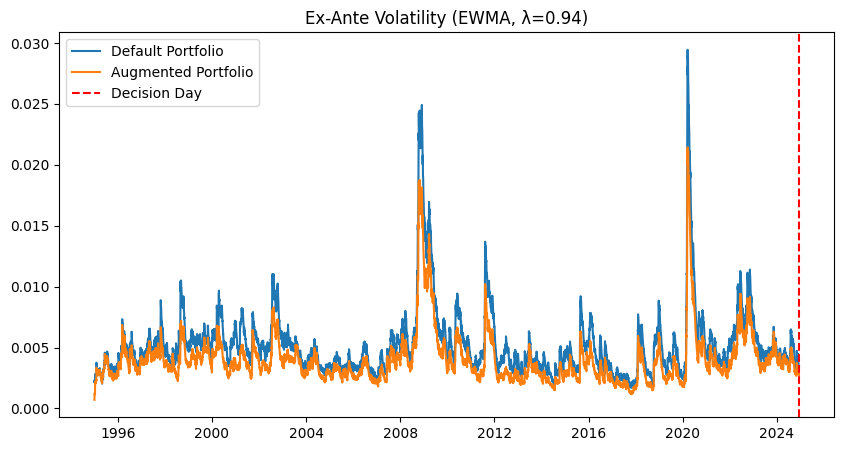

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(vol_default, label='Default Portfolio')
plt.plot(vol_augmented, label='Augmented Portfolio')
plt.axvline(x=decision_day, color='red', linestyle='--', label='Decision Day')
plt.title("Ex-Ante Volatility (EWMA, λ=0.94)")
plt.legend()
plt.show()

- We estimated the ex-ante volatility of the default and augmented portfolios as of 11-Dec-2024 using the EWMA model with λ = 0.94, a commonly used parameter that emphasizes recent data while smoothing short-term noise.

- Portfolio-level returns were computed by applying the respective asset weights to daily log returns. The resulting EWMA volatility time series shows similar dynamics for both portfolios, with notable spikes during major crises (e.g., 2008, 2020).

- However, the augmented portfolio consistently exhibits lower volatility, reflecting its more defensive allocation (more Treasuries, no Oil, reduced Equities).

In [ ]:
'''Volatility Horizon Selected:
--> daily volatility horizon, consistent with the PM’s weekly trading frequency.

Models Selected:
Applied the Exponentially Weighted Moving Average (EWMA) model using λ = 0.94, a standard industry parameter (this is what I found).

--> Maybe try also GARCH for comparison.

Estimation Approach:
Computed daily log returns from price indices and constructed portfolio returns using the specified asset weights.
EWMA volatility was estimated using the full historical window from 1994 to 2024, providing a long-term out-of-sample view.

Evaluation Criteria 
As a first step, we visually assessed the volatility dynamics of both portfolios and compared values on the decision date (11-Dec-2024).
Ex-Ante Volatility Over Time:
The EWMA model captures historical spikes (e.g., 2008, 2020), showing meaningful differences between portfolios, particularly during periods of stress.'''

## RQ 2 – downside risk : 
### what are the ex-ante VaRs of the augmented & default portfolios on Wednesday 11-Dec-2024 close and how does this compare against the course of these ex-ante VaRs over time ?

In [16]:
z_95 = -1.645

# Calculate parametric VaR for both portfolios
var_default_param = z_95 * vol_default
var_augmented_param = z_95 * vol_augmented

# Extract the VaR value for 11-Dec-2024
var_default_11dec = var_default_param.loc['2024-12-11']
var_augmented_11dec = var_augmented_param.loc['2024-12-11']

# Display results
print(f"Parametric 1-day 95% VaR on 11-Dec-2024:")
print(f"  - Default Portfolio:   {var_default_11dec:.4%}")
print(f"  - Augmented Portfolio: {var_augmented_11dec:.4%}")

Parametric 1-day 95% VaR on 11-Dec-2024:
  - Default Portfolio:   -0.5661%
  - Augmented Portfolio: -0.4482%


#### - Parametric VaR assumes normality and uses EWMA volatility (λ = 0.94) to capture recent changes in market risk.

In [17]:
# Rolling window size (250 trading days ≈ 1 year)
window = 250
quantile = 0.05

# Calculate non-parametric (historical) VaR using rolling 5th percentile
var_default_hist = ret_default.rolling(window).quantile(quantile)
var_augmented_hist = ret_augmented.rolling(window).quantile(quantile)

# Extract values for 11-Dec-2024
var_default_hist_11dec = var_default_hist.loc['2024-12-11']
var_augmented_hist_11dec = var_augmented_hist.loc['2024-12-11']

# Display results
print(f"Non-Parametric (Historical) 1-day 95% VaR on 11-Dec-2024:")
print(f"  - Default Portfolio:   {var_default_hist_11dec:.4%}")
print(f"  - Augmented Portfolio: {var_augmented_hist_11dec:.4%}")

Non-Parametric (Historical) 1-day 95% VaR on 11-Dec-2024:
  - Default Portfolio:   -0.6678%
  - Augmented Portfolio: -0.5532%


#### - Historical VaR is non-parametric and based on the 5th percentile of a 250-day rolling window of actual returns.

In [18]:
# Align lengths by dropping NaNs
var_default_combined = pd.DataFrame({
    'Parametric': var_default_param,
    'Historical': var_default_hist
}).dropna()

var_augmented_combined = pd.DataFrame({
    'Parametric': var_augmented_param,
    'Historical': var_augmented_hist
}).dropna()

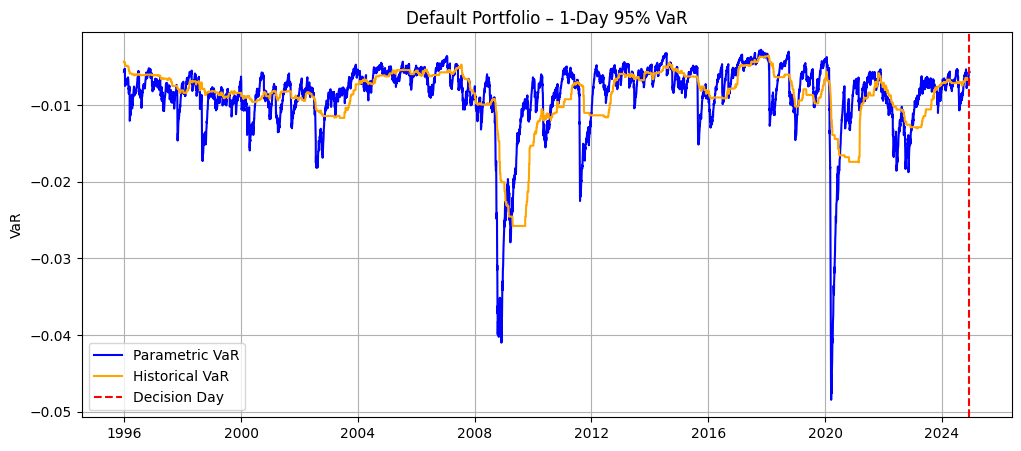

In [19]:
# Plot Default Portfolio VaR
plt.figure(figsize=(12, 5))
plt.plot(var_default_combined['Parametric'], label='Parametric VaR', color='blue')
plt.plot(var_default_combined['Historical'], label='Historical VaR', color='orange')
plt.axvline(pd.to_datetime('2024-12-11'), color='red', linestyle='--', label='Decision Day')
plt.title('Default Portfolio – 1-Day 95% VaR')
plt.ylabel('VaR')
plt.legend()
plt.grid(True)
plt.show()

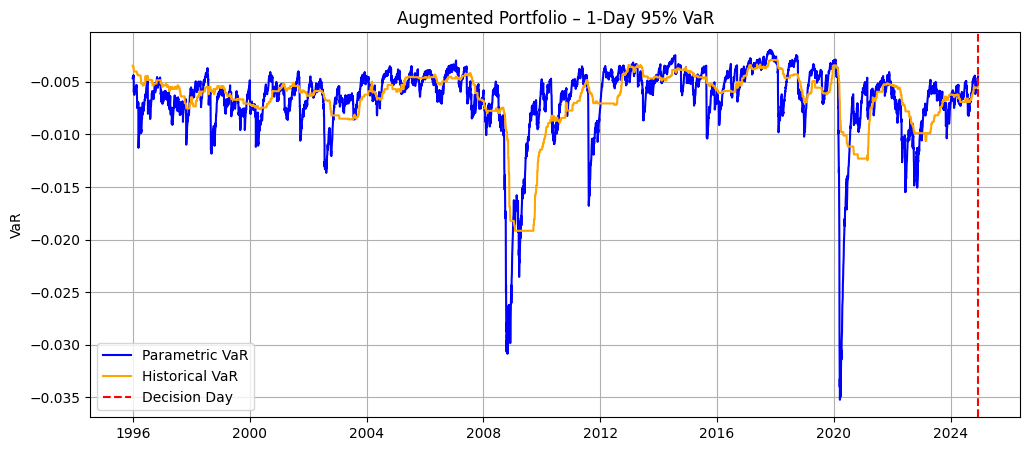

In [20]:
# Plot Augmented Portfolio VaR
plt.figure(figsize=(12, 5))
plt.plot(var_augmented_combined['Parametric'], label='Parametric VaR', color='blue')
plt.plot(var_augmented_combined['Historical'], label='Historical VaR', color='orange')
plt.axvline(pd.to_datetime('2024-12-11'), color='red', linestyle='--', label='Decision Day')
plt.title('Augmented Portfolio – 1-Day 95% VaR')
plt.ylabel('VaR')
plt.legend()
plt.grid(True)
plt.show()

### On 11-Dec-2024, both models indicate that the augmented portfolio carries lower downside risk than the default portfolio, both its parametric and historical VaR estimates are less negative than those of the default portfolio on 11-Dec-2024. This aligns with its more defensive allocation. Over time, the augmented portfolio consistently shows lower VaR estimates across both methods.